# Evaluate your Classifier's Performance - Don't Neglect Uncertainty!

Metrics such as sensitivity, specificity etc. are needed to evaluate how well binary classifiers work. 
These are calculated from the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) which lists true positive (TP), true negative (TN), false positive (FP) and false negative (FN) predictions.

If the sample size is small, these metrics are highly uncertain as we have shown in our manuscript. If you want to determine the uncertainty of your classifier's metric, use this tool. All settings are identical to the protocol in our paper.

# Options

Currently, you can do the following here:

1. Calculate and visualize uncertainty of a metric for a single classifier
2. Compare the posterior distributions of the same metric for two classifiers
3. Estimate the sample size necessary to reduce metric uncertainty to an acceptable level

## 1. Metric uncertainty for 1 classifier

All you have to do (boxes on the left side, from top to bottom):

1. Enter your confusion matrix
2. Select your metric of interest (nomenclature follows [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix))
3. Select boundaries to integrate $\int_{low}^{high} p(\mathrm{metric} | D) d\theta$

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', **{'size': 36})

import pandas as pd
import seaborn as sns
import ipywidgets


from __init__ import ConfusionMatrixAnalyser, NewPrevalence, BetaBinomialDist
from classifier_comparison import classifier_outperformance

In [2]:
analyser = ConfusionMatrixAnalyser(pd.Series([5, 5, 5, 5], index=['TP', 'FN', 'TN', 'FP']))

In [3]:
def generate_cma(TP, TN, FN, FP):
    cm = pd.Series({'TP': int(TP),
                    'TN': int(TN),
                    'FN': int(FN),
                    'FP': int(FP)})
    
    analyser = ConfusionMatrixAnalyser(cm)
    return analyser

In [4]:
trigger = 'Please select'

In [5]:
def catch_select(metric):
    if metric == trigger:
        return 'BM'
    else:
        return metric

In [6]:
def plot_metric(TP, TN, FN, FP, 
                metric='BM', point_estimate=True, theta=True, posterior_prediction=False):

    analyser = generate_cma(TP, TN, FN, FP)
    
    metric = catch_select(metric)
    
    plt.figure(figsize=(12, 8))
    plt.rc('font', size=22) 
    analyser.plot_metric(metric, 
                         theta, 
                         posterior_prediction,
                         point_estimate)

In [7]:
def integrate(TP, TN, FN, FP, 
              metric='BM', low_bound=-1., high_bound=1.):
    
    analyser = generate_cma(TP, TN, FN, FP)

    metric = catch_select(metric)

    integral = analyser.integrate_metric(metric, 
                                  low_bound, 
                                  high_bound)
    
    print('Probability that %s < %s < %s: %s' % (str(low_bound), metric, str(high_bound), str(integral*100)) + '%')

In [8]:
def print_hpd(TP, TN, FN, FP, 
              metric='BM'):
    
    analyser = generate_cma(TP, TN, FN, FP)
    
    metric = catch_select(metric)
    
    hpd = analyser.calc_hpd(analyser.theta_metrics[metric])
    
    print('95% credible interval: ' + str(hpd))

In [9]:
def print_metric_definition(metric):
    metric = catch_select(metric)
    
    print(metric + ' = ')
    print(analyser.metrics['symbolic'][metric])
    print('\n')

In [10]:
# generate necessary inputs
tp, tn, fn, fp = [ipywidgets.Text('5') for i in range(4)]

low_bound = ipywidgets.FloatSlider(value=0., min=-1., max=1., step=0.1)
high_bound = ipywidgets.FloatSlider(value=1., min=-1., max=1., step=0.1)

# add fake entry or not?
metric_dropdown = ipywidgets.Dropdown(options=[trigger] + list(analyser.theta_metrics.columns), value=trigger)
metric_dropdown = ipywidgets.ToggleButtons(options=list(analyser.theta_metrics.columns), value='BM')

point_estimate = ipywidgets.Checkbox(value=True, description='point estimate')
theta = ipywidgets.Checkbox(value=True, description='Bayes')
empirical = ipywidgets.Checkbox(description='empirical')

plt.figure()
plot = ipywidgets.interactive(plot_metric, 
                              TP=tp,TN=tn,FN=fn,FP=fp,
                              metric=metric_dropdown, 
                              point_estimate=point_estimate, theta=theta, empirical=empirical)
integration = ipywidgets.interactive(integrate, 
                                     TP=tp,TN=tn,FN=fn,FP=fp,
                                     metric=metric_dropdown, low_bound=low_bound, high_bound=high_bound)
hpd = ipywidgets.interactive(print_hpd, 
                             TP=tp,TN=tn,FN=fn,FP=fp,
                             metric=metric_dropdown)
metric = ipywidgets.interactive(print_metric_definition,
                               metric=metric_dropdown)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
layout_settings = {'display': 'flex',
                   'flex_flow': 'column',
                   'align_items': 'stretch',
                   'border': 'solid'}

input_layout = ipywidgets.Layout(width='35%', **layout_settings)

output_layout = ipywidgets.Layout(width='65%', **layout_settings)

In [12]:
box_layout_full = ipywidgets.Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    border='dashed',
                    width='100%')

In [13]:
cm_box = ipywidgets.VBox(children=plot.children[:4], layout=box_layout_full)

In [14]:
plotting_box = ipywidgets.VBox(children=plot.children[4:5] +  metric.children[-1:] + plot.children[5:8], layout=box_layout_full)

In [15]:
integration_box = ipywidgets.VBox(children=integration.children[5:-1], layout=box_layout_full)

In [16]:
input_box = ipywidgets.VBox(children=[cm_box, plotting_box, integration_box], layout=input_layout)
output_box = ipywidgets.VBox(children=[plot.children[-1], hpd.children[-1], integration.children[-1]], layout=output_layout)

In [17]:
fullbox = ipywidgets.HBox(children=[input_box, output_box])

In [18]:
display(fullbox)

## 2. Compare posterior distributions for two classifiers

We will use the same confusion matrix from above for classifier A, you only need to input the one for classifier B.

In [19]:
tp2, tn2, fn2, fp2 = [ipywidgets.Text('8'), ipywidgets.Text('4'), ipywidgets.Text('2'), ipywidgets.Text('6')]

In [20]:
def plot_classifier_comparison(TP, TN, FN, FP,
                               TP2, TN2, FN2, FP2,
                               metric='BM', point_estimate=True, theta=True, posterior_prediction=False):
    
    analyser1 = generate_cma(TP, TN, FN, FP)
    analyser2 = generate_cma(TP2, TN2, FN2, FP2)

    metric = catch_select(metric)
    
    plt.figure(figsize=(12, 8))
    plt.rc('font', size=22) 
    
    analyser1.plot_metric(metric, 
                         theta, 
                         posterior_prediction,
                         point_estimate)
    analyser2.plot_metric(metric, 
                         theta, 
                         posterior_prediction,
                         point_estimate)

In [21]:
def calc_outperformance_probability(TP, TN, FN, FP,
                               TP2, TN2, FN2, FP2,
                               metric='BM'):
    
    analyser1 = generate_cma(TP, TN, FN, FP)
    analyser2 = generate_cma(TP2, TN2, FN2, FP2)

    metric = catch_select(metric)
    
    outperformance = (analyser1.theta_metrics[metric] >  analyser2.theta_metrics[metric]).sum()
    outperformance /= float(len(analyser1.theta_metrics[metric]))

    print('Chance that classifier 1 is better than classifier 2 w.r.t. %s: %d' % (metric, np.round(outperformance*100)) + '%')

In [22]:
plot_comparison = ipywidgets.interactive(plot_classifier_comparison, 
                              TP=tp,TN=tn,FN=fn,FP=fp,
                              TP2=tp2,TN2=tn2,FN2=fn2,FP2=fp2,
                              metric=metric_dropdown)

outperformance_comparison = ipywidgets.interactive(calc_outperformance_probability, 
                              TP=tp,TN=tn,FN=fn,FP=fp,
                              TP2=tp2,TN2=tn2,FN2=fn2,FP2=fp2,
                              metric=metric_dropdown)

In [23]:
cm2_box = ipywidgets.VBox(children=plot_comparison.children[4:8], layout=box_layout_full)

In [24]:
comparison_input_box = ipywidgets.VBox(children=[cm_box, cm2_box, plotting_box], layout=input_layout)
comparison_output_box = ipywidgets.VBox(children=[plot_comparison.children[-1], outperformance_comparison.children[-1]], layout=output_layout)

In [25]:
comparison_fullbox = ipywidgets.HBox(children=[comparison_input_box, comparison_output_box])

In [26]:
comparison_fullbox

## 3. Sample size estimation

In our manuscript, we have shown that metric uncertainty (MU) can be approximated for $N$>20 by 

$$
MU = \frac{2}{\sqrt{N}}
$$

where $N$ is the sample size. $N$ can mean different things depending on the metric:

| metric | interpretation |
|-----|----------------|
|PREVALENCE| all samples | 
| ACC | all samples    |
| TPR | real positives |
| TNR | real negatives |
| PPV | predicted positives|
| NPV | predicted negatives|

Please note that this only serves as a rule of thumb! It will give you a realistic order of magnitude which allows you to determine if a level of uncertainty is achievable. It obviously neglects any previous information that you have about your classifier.

In [27]:
warning_message = "This rule of thumb is only reasonable if N>20, MU < 45%!!"

def calc_MU(N):
    N = int(N)
    MU = 2. / np.sqrt(N)
    formatted_string = r'       MU = %2.1e = %3.1f' %  (MU, MU * 100) + '%'
    
    if N <= 20 or MU >= 0.45:
        print(warning_message)
    else:
        print(formatted_string)

ipywidgets.interact(calc_MU, N='100')

def calc_N(MU):
    MU = float(MU)
    N = 4. / MU**2
    formatted_string = r'        N = %2.1e = %d' %  (N, np.round(N))
    
    
    if N <= 20 or MU >= 0.45:
        print(warning_message)
    else:
        print(formatted_string)

ipywidgets.interact(calc_N, MU='0.01')

        N = 4.0e+04 = 40000


<function __main__.calc_N(MU)>

<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>

# Please ignore everything below, it is redundant and only needed to ensure that everything works correctly.

<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>

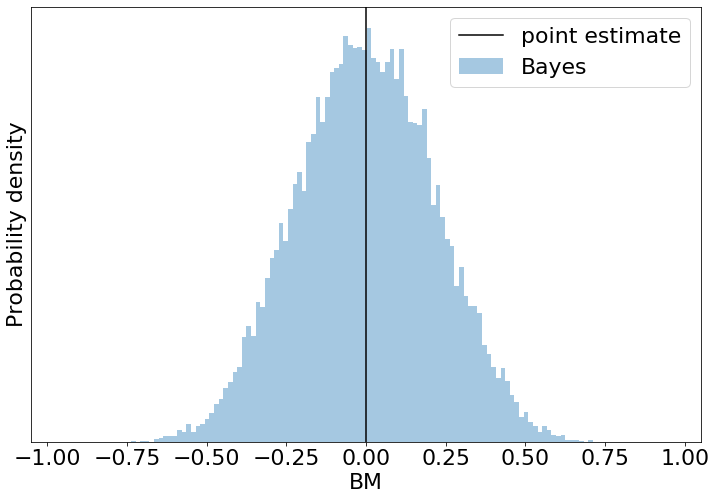

In [28]:
plot
integration
hpd 
metric

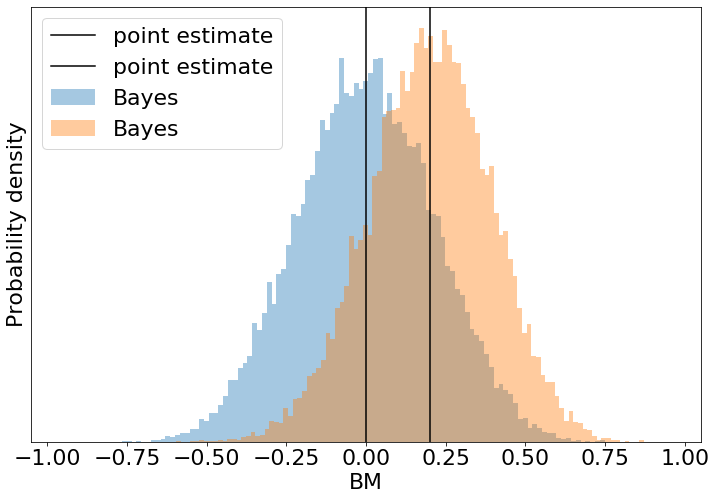

In [29]:
plot_comparison
outperformance_comparison